<a href="https://colab.research.google.com/github/lasiadhi/Prediction-of-hypoxemia-trend/blob/master/outcome_generation_option2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#################################################
###### @author: Lasith Adhikari (python 3)  #####
############ Created on Nov 25, 2019 ############
# Code description: 
# Generate hypoxemia change/transition using the first PF value (PF1) after IV start and first PF after PF1 time + 24h 

In [1]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import tensorflow as tf

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [0]:
from google.colab import files
import seaborn as sns
import pickle
import matplotlib.pyplot as plt 
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [0]:
auth.authenticate_user()

In [0]:
# Note that this should be the project for the datathon work,
# not the physionet-data project which is for data hosting.
project_id = 'hst-953-2019'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

In [0]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

In [6]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# read ICU IV start times:
first_icuid_dict = pickle.load(open("/content/drive/My Drive/Colab Notebooks/data/IV_LOS24_adult_firstICU_dict.pkl", "rb" ) )

In [8]:
len(first_icuid_dict.keys())

38823

In [0]:
# Were there any first ICU eps had start time missing? 0
cn = 0
for i in first_icuid_dict.keys():
  first_ep = first_icuid_dict[i]['IV'][0]
  if np.isnan(first_ep[0]):
    cn += 1
print(cn)

0


In [0]:
# Were there any first ICU eps had end time missing? 8143
cn = 0
for i in first_icuid_dict.keys():
  first_ep = first_icuid_dict[i]['IV'][0]
  if np.isnan(first_ep[1]):
    cn += 1
print(cn)

8143


In [0]:
# read PF values
#both_p_f = pickle.load(open("/content/drive/My Drive/Colab Notebooks/data/both_p_f", "rb" ) )
#impute_p_f = pickle.load(open("/content/drive/My Drive/Colab Notebooks/data/impute_p_f", "rb" ) )

In [0]:
#both_p_f.patientunitstayid.nunique()

6807

## Compute PF-ratio

In [0]:
df_outcome = run_query("""
select patientunitstayid, chartoffset, fio2, pao2
from `physionet-data.eicu_crd_derived.pivoted_bg` 
order by patientunitstayid, chartoffset
"""
)

In [10]:
df_outcome.head()

,patientunitstayid,chartoffset,fio2,pao2
0,141168,516,NaN,NaN
1,141168,1133,NaN,NaN
2,141168,1805,0.28,41.0
3,141168,2010,1.00,42.0
4,141168,2026,NaN,68.0


In [0]:
df_outcome_NL = df_outcome[df_outcome.pao2.notnull()].reset_index(drop=True)

In [12]:
df_outcome_NL


,patientunitstayid,chartoffset,fio2,pao2
0,141168,1805,0.28,41.0
1,141168,2010,1.00,42.0
2,141168,2026,NaN,68.0
3,141168,2141,NaN,121.0
4,141194,2102,0.28,100.0
...,...,...,...,...
414345,3353251,4510,0.40,72.0
414346,3353251,5598,0.40,68.0
414347,3353251,9901,0.45,80.0
414348,3353251,11054,0.40,87.0


In [0]:
# fill forward fio2 values within each pts id.
df_outcome_NL.fio2 = df_outcome_NL.groupby('patientunitstayid')['fio2'].ffill()

In [14]:
df_outcome_NL

,patientunitstayid,chartoffset,fio2,pao2
0,141168,1805,0.28,41.0
1,141168,2010,1.00,42.0
2,141168,2026,1.00,68.0
3,141168,2141,1.00,121.0
4,141194,2102,0.28,100.0
...,...,...,...,...
414345,3353251,4510,0.40,72.0
414346,3353251,5598,0.40,68.0
414347,3353251,9901,0.45,80.0
414348,3353251,11054,0.40,87.0


In [0]:
# now drop any rows with fio2 still null
df_outcome_NL = df_outcome_NL[df_outcome_NL.fio2.notnull()]

In [16]:
df_outcome_NL

,patientunitstayid,chartoffset,fio2,pao2
0,141168,1805,0.28,41.0
1,141168,2010,1.00,42.0
2,141168,2026,1.00,68.0
3,141168,2141,1.00,121.0
4,141194,2102,0.28,100.0
...,...,...,...,...
414344,3353251,3864,0.40,73.0
414345,3353251,4510,0.40,72.0
414346,3353251,5598,0.40,68.0
414347,3353251,9901,0.45,80.0


In [17]:
df_outcome_NL.pao2.describe()

count    327629.000000
mean        120.640156
std          82.043248
min          15.000000
25%          73.000000
50%          93.000000
75%         134.000000
max         702.000000
Name: pao2, dtype: float64

In [18]:
# compute the PF-ratio:
df_outcome_NL['pf_ratio'] = round(df_outcome_NL['pao2']/df_outcome_NL['fio2'],2)
df_outcome_NL.loc[df_outcome_NL['pf_ratio']>1000,'pf_ratio']=1000.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [19]:
df_outcome_NL['pf_ratio'].describe()

count    327629.000000
mean        239.056291
std         141.917658
min          15.000000
25%         141.670000
50%         212.750000
75%         307.000000
max        1000.000000
Name: pf_ratio, dtype: float64

In [20]:
df_outcome_NL

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
0,141168,1805,0.28,41.0,146.43
1,141168,2010,1.00,42.0,42.00
2,141168,2026,1.00,68.0,68.00
3,141168,2141,1.00,121.0,121.00
4,141194,2102,0.28,100.0,357.14
...,...,...,...,...,...
414344,3353251,3864,0.40,73.0,182.50
414345,3353251,4510,0.40,72.0,180.00
414346,3353251,5598,0.40,68.0,170.00
414347,3353251,9901,0.45,80.0,177.78


In [21]:
(df_outcome_NL.chartoffset/60.0).describe()

count    327629.000000
mean         76.057297
std        1405.238547
min     -788659.500000
25%           3.100000
50%          26.933333
75%         101.750000
max        6802.616667
Name: chartoffset, dtype: float64

In [22]:
# no of icu stays in pf ratio dataset:
df_outcome_NL.patientunitstayid.nunique()

65643

In [0]:
# Pick the PF1 value close to IV start time:

In [0]:
first_pf = pd.DataFrame()
for icu_id in first_icuid_dict.keys():
  MV_list = first_icuid_dict[icu_id]['IV']
  first_MV_start = MV_list[0][0]
  #MV_plus_24hr =   first_MV_start + 24.0 # watch period end time from the first MV

  for MV_i in MV_list: # start from the begining 
      found_pf = 0 # set to 1 once we found a valid pf value

        # read all PF-ratio values first
      pf_both_df = df_outcome_NL[df_outcome_NL.patientunitstayid==icu_id].sort_values(by='chartoffset', ascending=True).reset_index(drop=True)
      pf_both_df['chartoffset'] = pf_both_df['chartoffset']/60.0

      for i,row in pf_both_df.iterrows():
        if ((row['chartoffset']) <= MV_i[1]) & ((row['chartoffset']) >= MV_i[0]):
          temp = pd.DataFrame({'patientunitstayid': [icu_id],'chartoffset_hrs':[row['chartoffset']], 'pf_ratio': [row['pf_ratio']]})
          first_pf = pd.concat([first_pf, temp])
          found_pf = 1
          break 

      if found_pf==1: 
         break  

In [0]:
def hypo_outcome(x):
  if x<=100.0:
    return 'severe'
  elif (x>100) & (x<=200):
    return 'moderate'
  elif (x>200) & (x<=300):
    return 'mild'
  else:
    return 'no hypoxemia'

In [0]:
first_pf['hyp_cat'] = first_pf.pf_ratio.apply(hypo_outcome)

In [27]:
first_pf.head()

,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,141451,1.250000,161.00,moderate
0,141515,1.500000,283.00,mild
0,141806,1.416667,176.67,moderate
0,141844,0.983333,260.00,mild
0,141853,1.083333,198.33,moderate


In [28]:
first_pf.patientunitstayid.nunique()

22534

In [0]:
# Pick the PF2 value close to PF1 time + 24hr for the patients in first_pf: 

In [0]:
first24hr_pf = pd.DataFrame()
for icu_id in first_pf.patientunitstayid.unique():
  MV_list = first_icuid_dict[icu_id]['IV']
  first_PF_time = first_pf.loc[first_pf.patientunitstayid==icu_id,'chartoffset_hrs'].values[0]
  #print(first_PF_time)
  MV_plus_24hr =   first_PF_time + 24.0 # watch period end time from the first MV

  for MV_i in MV_list: # start from the begining 
      found_pf = 0 # set to 1 once we found a valid pf value

      # read all PF-ratio values first
      pf_both_df = df_outcome_NL[df_outcome_NL.patientunitstayid==icu_id].sort_values(by='chartoffset', ascending=True).reset_index(drop=True)
      pf_both_df['chartoffset'] = pf_both_df['chartoffset']/60.0

      for i,row in pf_both_df.iterrows():
        if ((row['chartoffset']) <= MV_i[1]) & ((row['chartoffset']) >= max(MV_plus_24hr, MV_i[0])):
          temp = pd.DataFrame({'patientunitstayid': [icu_id],'chartoffset_hrs':[row['chartoffset']], 'pf_ratio': [row['pf_ratio']]})
          first24hr_pf = pd.concat([first24hr_pf, temp])
          found_pf = 1
          break 

      if found_pf==1: 
         break  

In [0]:
first24hr_pf['hyp_cat'] = first24hr_pf.pf_ratio.apply(hypo_outcome)

In [36]:
first24hr_pf.head()

,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,141515,33.166667,195.00,moderate
0,142173,41.633333,105.00,moderate
0,144173,32.016667,296.67,mild
0,144548,28.783333,176.00,moderate
0,144770,139.883333,218.00,mild


In [37]:
first24hr_pf.patientunitstayid.nunique()

9668

In [38]:
first24hr_pf.chartoffset_hrs.describe()

count    9668.000000
mean       57.908173
std        56.158777
min      -249.200000
25%        33.350000
50%        41.733333
75%        62.354167
max      1674.750000
Name: chartoffset_hrs, dtype: float64

In [39]:
first24hr_pf[first24hr_pf.chartoffset_hrs<30].shape

(1373, 4)

In [0]:
# sanity check  

In [41]:
# Example 1:
first_icuid_dict[141515]

{'ICU Admit': [0], 'ICU Discharge': [148.03], 'IV': [(0.27, 148.03)]}

In [42]:
df_outcome_NL[df_outcome_NL.patientunitstayid==141515]

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
100,141515,90,1.0,283.0,283.00
101,141515,200,0.5,55.0,110.00
102,141515,270,0.7,71.0,101.43
103,141515,425,0.7,85.0,121.43
104,141515,575,0.7,133.0,190.00
105,141515,1145,0.4,87.0,217.50
106,141515,1990,0.4,78.0,195.00
107,141515,2610,0.4,126.0,315.00
108,141515,4075,0.4,104.0,260.00
109,141515,5520,0.4,100.0,250.00


In [43]:
first24hr_pf[first24hr_pf.patientunitstayid==141515]

,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,141515,33.166667,195.0,moderate


In [44]:
first_pf[first_pf.patientunitstayid==141515]

,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,141515,1.5,283.0,mild


In [46]:
# Example 2:
first_icuid_dict[142173]

{'ICU Admit': [0],
 'ICU Discharge': [622.22],
 'IV': [(0.38, 604.6), (604.63, nan)]}

In [47]:
df_outcome_NL[df_outcome_NL.patientunitstayid==142173]

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
316,142173,-166,0.40,90.0,225.00
317,142173,-56,1.00,131.0,131.00
318,142173,131,0.80,70.0,87.50
319,142173,711,0.80,69.0,86.25
320,142173,2498,0.80,84.0,105.00
321,142173,3079,0.80,102.0,127.50
322,142173,3619,0.55,87.0,158.18
323,142173,4939,0.55,80.0,145.45
324,142173,6404,0.50,82.0,164.00
325,142173,7771,0.50,60.0,120.00


In [48]:
first24hr_pf[first24hr_pf.patientunitstayid==142173]

,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,142173,41.633333,105.0,moderate


In [49]:
first_pf[first_pf.patientunitstayid==142173]

,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,142173,2.183333,87.5,severe


###  Let's merge first dataframe (near IV start) with last dataframe(near 24hr time point):

In [0]:
first_pf.rename(columns={'chartoffset_hrs':'chartoffset_hrs_first','pf_ratio':'pf_ratio_first','hyp_cat':'hyp_cat_first'}, inplace=True)

In [0]:
first24hr_pf.rename(columns={'chartoffset_hrs':'chartoffset_hrs_last','pf_ratio':'pf_ratio_last','hyp_cat':'hyp_cat_last'}, inplace=True)

In [0]:
first_last_label = pd.merge(first_pf, first24hr_pf, how='inner',on='patientunitstayid')

In [56]:
first_last_label.head()

,patientunitstayid,chartoffset_hrs_first,pf_ratio_first,hyp_cat_first,chartoffset_hrs_last,pf_ratio_last,hyp_cat_last
0,141515,1.500000,283.0,mild,33.166667,195.00,moderate
1,142173,2.183333,87.5,severe,41.633333,105.00,moderate
2,144173,1.200000,92.0,severe,32.016667,296.67,mild
3,144548,0.983333,232.0,mild,28.783333,176.00,moderate
4,144770,26.200000,154.0,moderate,139.883333,218.00,mild


In [57]:
first_last_label.patientunitstayid.nunique()

9668

In [0]:
# compute the time gap between first PF and last PF within first 24hr in MV:
first_last_label['time_gap'] = round(first_last_label.chartoffset_hrs_last - first_last_label.chartoffset_hrs_first,2)

In [0]:
# produce final label: worse (1), stable or better (0)

In [0]:
def worse_or_better(row):
  if (row['hyp_cat_first'] == 'no hypoxemia') & ((row['hyp_cat_last']=='mild') | (row['hyp_cat_last']=='moderate') | (row['hyp_cat_last']=='severe')):
    return 1
  elif (row['hyp_cat_first'] == 'mild') & ((row['hyp_cat_last']=='moderate') | (row['hyp_cat_last']=='severe')):
    return 1
  elif (row['hyp_cat_first'] == 'moderate') & (row['hyp_cat_last']=='severe'):
    return 1
  else:
    return 0

In [0]:
first_last_label['is_worse'] = first_last_label.apply(worse_or_better,axis=1)

In [62]:
first_last_label.head(10)

,patientunitstayid,chartoffset_hrs_first,pf_ratio_first,hyp_cat_first,chartoffset_hrs_last,pf_ratio_last,hyp_cat_last,time_gap,is_worse
0,141515,1.500000,283.00,mild,33.166667,195.00,moderate,31.67,1
1,142173,2.183333,87.50,severe,41.633333,105.00,moderate,39.45,0
2,144173,1.200000,92.00,severe,32.016667,296.67,mild,30.82,0
3,144548,0.983333,232.00,mild,28.783333,176.00,moderate,27.80,1
4,144770,26.200000,154.00,moderate,139.883333,218.00,mild,113.68,0
5,144954,7.366667,76.00,severe,35.533333,160.00,moderate,28.17,0
6,145164,2.050000,318.33,no hypoxemia,29.883333,420.00,no hypoxemia,27.83,0
7,145715,26.233333,135.00,moderate,75.616667,124.00,moderate,49.38,0
8,145867,1.416667,135.00,moderate,33.000000,124.00,moderate,31.58,0
9,146349,17.200000,197.50,moderate,79.366667,317.50,no hypoxemia,62.17,0


In [63]:
# let's drop samples if time gap<15hours:
#first_last_label_gap = first_last_label[first_last_label.time_gap>=12]
#first_last_label_gap.patientunitstayid.nunique()
first_last_label.time_gap.describe()

count    9668.000000
mean       40.931001
std        34.297411
min        24.000000
25%        26.900000
50%        32.770000
75%        43.120000
max      1357.750000
Name: time_gap, dtype: float64

In [64]:
first_last_label.hyp_cat_first.value_counts()

moderate        3162
no hypoxemia    2650
mild            2532
severe          1324
Name: hyp_cat_first, dtype: int64

Text(0, 0.5, '')

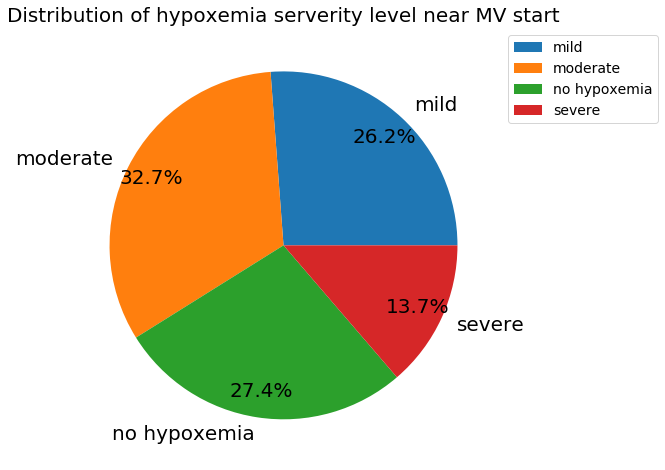

In [83]:
# plot distribution of hypo category at first and last time points:
# Near IV start:
pl = first_last_label.hyp_cat_first.value_counts().sort_index().plot.pie(figsize=(8, 8), autopct='%1.1f%%',\
                                                     pctdistance=0.85, labeldistance=1.1, textprops={'fontsize': 20})
pl.legend(prop={'size':14}, bbox_to_anchor=(1.0, 1.0))
pl.set_title('Distribution of hypoxemia serverity level near MV start', fontdict={'fontsize': 20})
pl.set_ylabel('')

In [66]:
# Near IV start+24h:
first_last_label.hyp_cat_last.value_counts().sort_index()

mild            3267
moderate        3214
no hypoxemia    2578
severe           609
Name: hyp_cat_last, dtype: int64

Text(0, 0.5, '')

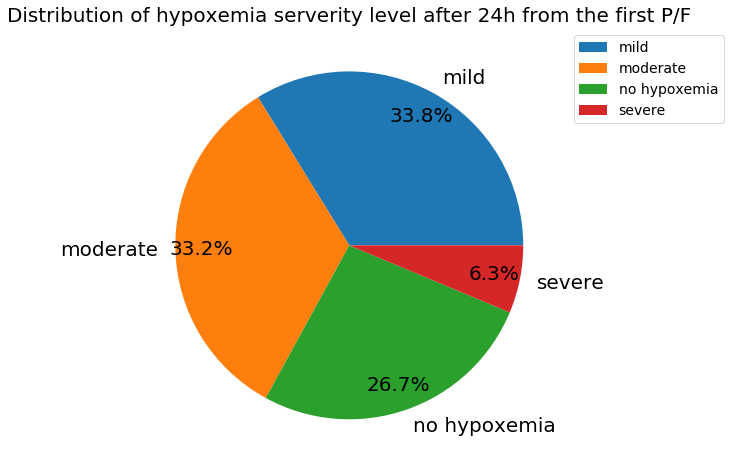

In [84]:
pl = first_last_label.hyp_cat_last.value_counts().sort_index().plot.pie(figsize=(8, 8), autopct='%1.1f%%',\
                                                     pctdistance=0.85, labeldistance=1.1, textprops={'fontsize': 20})
pl.legend(prop={'size':14}, bbox_to_anchor=(1.0, 1.0))
pl.set_title('Distribution of hypoxemia serverity level after 24h from the first P/F', fontdict={'fontsize': 20})
pl.set_ylabel('')

In [70]:
# outcome distribution:
first_last_label.is_worse.value_counts()

0    7515
1    2153
Name: is_worse, dtype: int64

Text(0, 0.5, '')

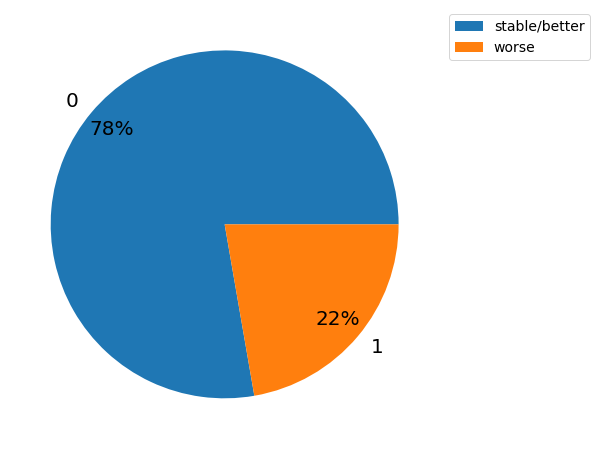

In [71]:
# plot the hypoxemia level distribution
pl = first_last_label.is_worse.value_counts().plot.pie(figsize=(8, 8), autopct='%1.0f%%',\
                                                     pctdistance=0.85, labeldistance=1.1, textprops={'fontsize': 20})
pl.legend(['stable/better', 'worse'], prop={'size':14}, bbox_to_anchor=(1.0, 1.0))
pl.set_ylabel('')

In [0]:
first_last_label_gap.to_csv('hypoxemia_outcome_with_12hr_gap.csv')
#files.download('hypoxemia_outcome_with_12hr_gap.csv')

In [72]:
first_last_label[first_last_label.chartoffset_hrs_last<0]

,patientunitstayid,chartoffset_hrs_first,pf_ratio_first,hyp_cat_first,chartoffset_hrs_last,pf_ratio_last,hyp_cat_last,time_gap,is_worse
1726,999150,-82.366667,178.57,moderate,-46.650000,264.00,mild,35.72,0
4592,2479203,-48.816667,85.50,severe,-20.183333,174.40,moderate,28.63,0
9138,1593789,-31.216667,75.79,severe,-5.600000,118.95,moderate,25.62,0
9353,3208898,-146.883333,38.00,severe,-119.833333,118.33,moderate,27.05,0
9356,3209249,-201.566667,280.00,mild,-177.016667,295.00,mild,24.55,0
9435,3222548,-277.533333,285.00,mild,-249.200000,347.50,no hypoxemia,28.33,0
9474,3230298,-46.416667,132.00,moderate,-14.416667,110.00,moderate,32.00,0
9496,3234211,-45.583333,146.00,moderate,-9.933333,126.00,moderate,35.65,0
9525,3238337,-32.416667,285.71,mild,-6.416667,220.00,mild,26.00,0


In [0]:

no_PF_ids = set(first_icuid_dict.keys())-set(first_last_label.patientunitstayid) # no any PF values at all or PF after first PF value time is not available

In [74]:
len(no_PF_ids)

29155

In [75]:
no_PF_ids

{1572869,
 262151,
 1835016,
 1572872,
 1572877,
 2228239,
 655378,
 2359321,
 3145760,
 3145763,
 655413,
 393272,
 3014713,
 1966141,
 2883649,
 3014725,
 2097227,
 1966157,
 1048654,
 2883665,
 2752594,
 1048668,
 2490468,
 2883685,
 655460,
 1572964,
 2883688,
 3014771,
 3014778,
 2097283,
 917634,
 2752650,
 2228362,
 3145868,
 1573005,
 1835155,
 1179797,
 1573027,
 1835172,
 1573028,
 1573042,
 3014838,
 524473,
 393404,
 1048767,
 2621632,
 1573054,
 1441993,
 1704142,
 3145940,
 1704152,
 2359516,
 393438,
 2883807,
 1966303,
 2883809,
 786657,
 524522,
 1442027,
 786673,
 3145983,
 1442048,
 2752772,
 2883850,
 2228492,
 1966350,
 1179919,
 2752783,
 2883856,
 1048851,
 3014941,
 393503,
 524577,
 786719,
 2097448,
 1048882,
 2490682,
 655675,
 2490685,
 2621758,
 1966402,
 1573196,
 2359629,
 1311054,
 1048911,
 2883919,
 1835346,
 3146068,
 917858,
 655719,
 1573229,
 3015025,
 524660,
 1048948,
 2490743,
 1180025,
 1966459,
 1573240,
 1835390,
 1180040,
 1704329,
 2228617,

In [77]:
# Example:
df_outcome_NL[df_outcome_NL.patientunitstayid==1970278]

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
257225,1970278,127,1.0,84.0,84.0
257226,1970278,725,0.5,76.0,152.0


In [78]:
first_icuid_dict[1970278]

{'ICU Admit': [0], 'ICU Discharge': [52.37], 'IV': [(1.38, 23.3)]}

In [79]:
# Example:
first_icuid_dict[2752960]

{'ICU Admit': [0], 'ICU Discharge': [81.4], 'IV': [(0.35, 53.28)]}

In [82]:
df_outcome_NL[df_outcome_NL.patientunitstayid==2752960]


,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
